<a href="https://colab.research.google.com/github/preetmodi/Credit-Risk-Analytics/blob/main/XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo echo -ne '\n' | sudo add-apt-repository ppa:alessandro-strada/ppa >/dev/null 2>&1 # note: >/dev/null 2>&1 is used to supress printing
!sudo apt update >/dev/null 2>&1
!sudo apt install google-drive-ocamlfuse >/dev/null 2>&1
!google-drive-ocamlfuse
!sudo apt-get install w3m >/dev/null 2>&1 # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop >/dev/null 2>&1 # to set default browser 
%cd /content
!mkdir gdrive
%cd gdrive
!mkdir "My Drive"
!google-drive-ocamlfuse "/content/gdrive/My Drive"

In [ ]:
!pip install git+https://github.com/CBravoR/scorecardpy

%cd /content/gdrive/My Drive/Data/

In [59]:
# Package loading
import pandas as pd
import numpy as np
import scorecardpy as sc
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
%matplotlib inline
seed = 251256517

In [5]:
# Import the files as Pandas datasets
# train_WoE = pd.read_csv('train_woe.csv')
# test_WoE = pd.read_csv('test_woe.csv')

train_noWoE = pd.read_pickle('model/data/train_no_woe.pkl')
test_noWoE = pd.read_pickle('model/data/test_no_woe.pkl')

# Give breaks for WoE
# with open('breaks_adj.json', 'r') as f:
#     breaks_adj = json.load(f)
# breaks_adj = {'Address': [1.0,2.0,8.0,17.0],
#               'Age': [30.0,45.0,50.0],
#               'Creddebt': [1.0, 6.0],
#               'Employ': [4.0,14.0,22.0],
#               'Income': [30.0,40.0,80.0,140.0],
#               'Leverage': [8.0,16.0,22.0],
#               'MonthlyLoad': [0.1,0.2,0.30000000000000004,0.7000000000000001],
#               'OthDebt': [1.0,2.0,3.0],
#               'OthDebtRatio': [0.01,0.05,0.07,0.09,0.14]
#               }

# Apply breaks.
# bins_adj = sc.woebin(train_noWoE, y="Default",
#                      breaks_list=breaks_adj)
  

In [27]:
from xgboost import XGBClassifier 
#Define the classifier.
XGB_lendingclub = XGBClassifier(max_depth=2,                 # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=50,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=-1,                    # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights. G / B
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=seed,        # Seed
                            tree_method='hist',           # How to train the trees?
#                             gpu_id=0                     # With which GPU? 
                            )

## Change these

In [40]:
param_grid = dict({'n_estimators': [900, 1000, 2000, 5000],
                   'max_depth': [3,4,5],
                 'learning_rate' : [0.05, 0.08, 0.1, 0.15]
                  })

In [19]:
categorical_features = list(set(train_noWoE.columns) - set(train_noWoE.describe().columns)) 
categorical_features.remove('earliest_cr_line')
# categorical_columns.remove('purpose')
train_noWoE = train_noWoE.drop(['earliest_cr_line'], axis = 1)

In [20]:
# Always a good idea to tune on a reduce sample of the train set, as we will call many functions.
val_train = train_noWoE.sample(frac = 0.5,               # The fraction to extract
                                       random_state = seed,    # The seed.
                                       )

## Run Grid Search


In [41]:
from sklearn.model_selection import GridSearchCV

# Define grid search object.
GridXGB = GridSearchCV(XGB_lendingclub,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = 3,              # Number of cross-validation folds.  
                       scoring = 'roc_auc', # How to rank outputs.
                       n_jobs = -1,          # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

# Follow the same approach for all categorical Variables

In [42]:

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_features)],
    remainder='passthrough'
)

# Now we define a Pipeline to process everything
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", GridXGB)]
)

# Train the XGB.
clf.fit(val_train.drop(columns='Default'), # X 
        val_train['Default']    # y
        )

Fitting 3 folds for each of 48 candidates, totalling 144 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['term', 'application_type',
                                                   'purpose',
                                                   'home_ownership'])])),
                ('classifier',
                 GridSearchCV(cv=3,
                              estimator=XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      callbacks=None,
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytre...
                                            

In [43]:
# Show best params
print(f'The best AUC is {GridXGB.best_score_:.3f}')
GridXGB.best_params_

The best AUC is 0.738


{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 2000}

# Train model on entire training dataset

In [71]:
# Create XGB with best parameters.
XGB_lendingclub = XGBClassifier(max_depth=GridXGB.best_params_.get('max_depth'), # Depth of each tree
                            learning_rate=GridXGB.best_params_.get('learning_rate'), # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=GridXGB.best_params_.get('n_estimators'), # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=-1,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=seed,        # Seed
                            tree_method='gpu_hist',       # How to train the trees?
                            gpu_id=0                      # With which GPU?
                            )

In [72]:
# Train over all training data.

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_features)],
    remainder='passthrough'
)

# Now we define a Pipeline to process everything
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", XGB_lendingclub)]
)

# Train the XGB.
clf.fit(train_noWoE.drop(columns='Default'), # X 
                  train_noWoE['Default']    # y
                  )

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['term', 'application_type',
                                                   'purpose',
                                                   'home_ownership'])])),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=No...
                               feature_types=None, gamma=0.001, gpu_id=0,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.05,
                               max_bin=256, max_cat

In [73]:
import pickle
with open('model/xgboost.pkl', 'wb') as fp:
    pickle.dump(XGB_lendingclub, fp)

# Variable Importance

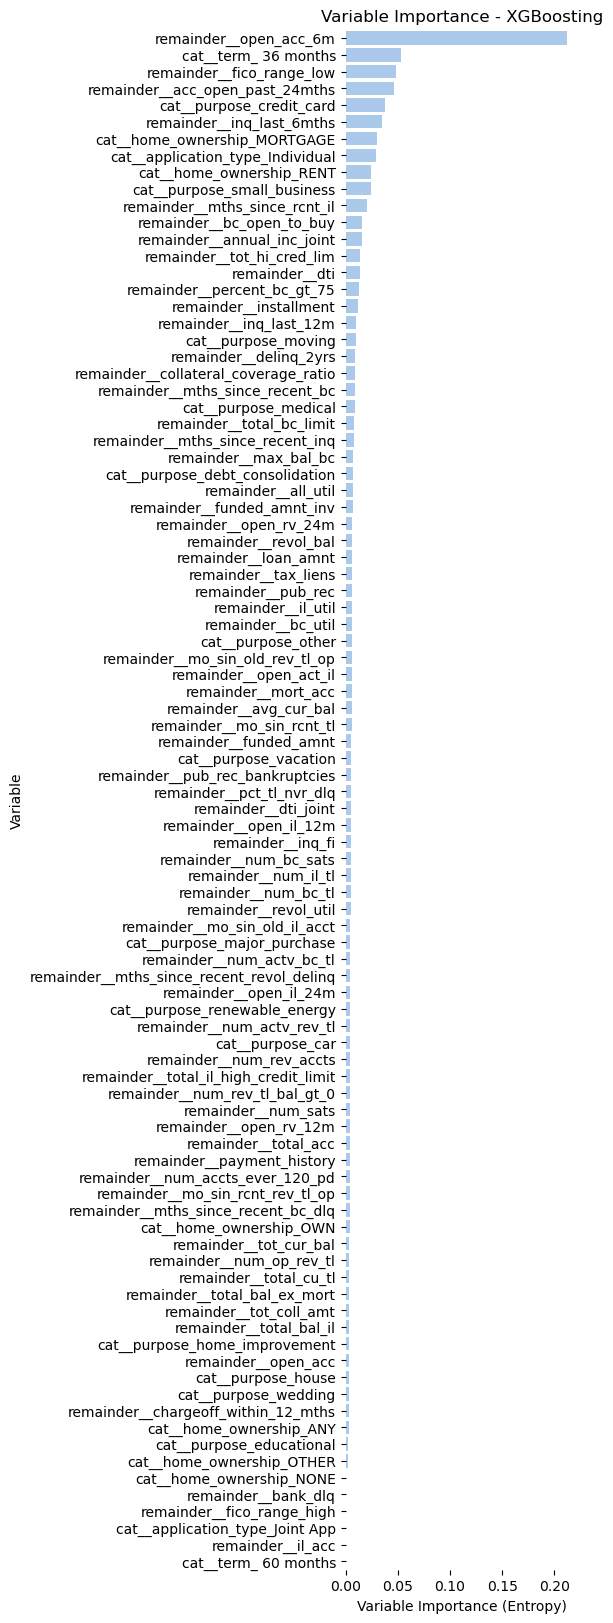

In [74]:
# Plot variable importance
importances = XGB_lendingclub.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 20))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[clf[:-1].get_feature_names_out()[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

### Confusion Matrix

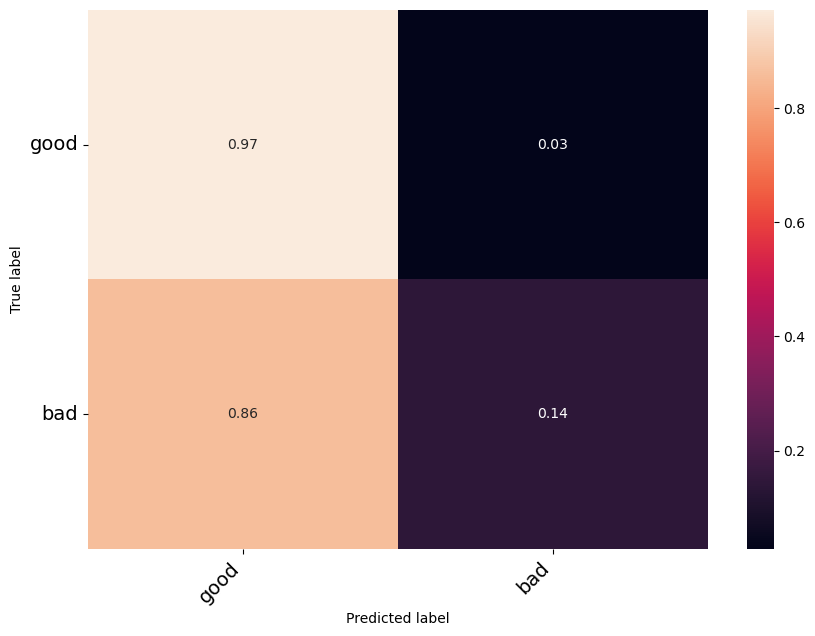

In [75]:
# Calculate probability
XGBClassTest = clf.predict(test_noWoE.drop(columns="Default"))
xg_probs_test = clf.predict_proba(test_noWoE.drop(columns="Default"))
xg_probs_test = xg_probs_test[:, 1]

# Calculate confusion matrix
confusion_matrix_xgb = confusion_matrix(y_true = test_noWoE['Default'], 
                    y_pred = XGBClassTest)

# Turn matrix to percentages
confusion_matrix_xgb = confusion_matrix_xgb.astype('float') / confusion_matrix_xgb.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_xgb, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

## ROC AUC

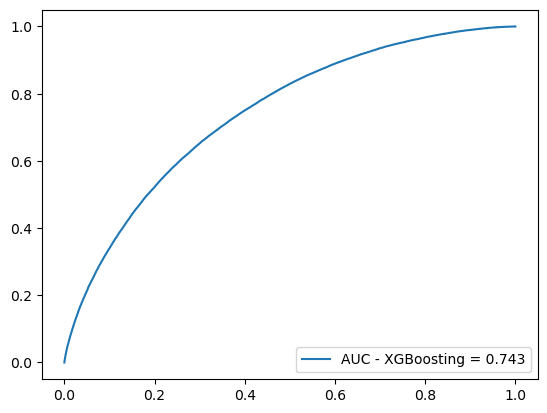

In [76]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_noWoE['Default'], 
                                 xg_probs_test)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_noWoE['Default'], 
                             y_score = xg_probs_test),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()

## Bootstapping to calculate error rates

In [77]:
# Write a Bootstrap function that calculates the different AUCs
def BootstrapPredErr(pred_prob, y_true, num_samples=1000):
    n = len(pred_prob)
    full_data = pd.DataFrame({'y_score':pred_prob, 'y_true':y_true})
    err = np.zeros(num_samples)    
    for i in range(num_samples):
        d = full_data.sample(n, replace=True)
        err[i] = np.round(roc_auc_score(y_true=d['y_true'], 
                             y_score=d['y_score']),
                             decimals=3
                          )
    return err

In [78]:
# Apply bootstrapping
auc_boot = BootstrapPredErr(pred_prob=xg_probs_test,  
                            y_true=test_noWoE['Default'])
upper=np.quantile(auc-auc_boot, 0.975, axis=0)
lower=np.quantile(auc-auc_boot, 0.025, axis=0)

# Compute confidence interval
boot_ci = [auc - upper, 
           auc - lower]
print(f"AUC Confidence Interval: [{boot_ci[0]:.3f}, {boot_ci[1]:.3f}]")

AUC Confidence Interval: [0.741, 0.744]


#Shap Values

In [66]:
# !pip install shap

In [67]:
import shap
shap.initjs() # Import Java engine.

In [86]:
test_noWoE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384185 entries, 2 to 1280642
Data columns (total 74 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   loan_amnt                       384185 non-null  float64
 1   funded_amnt                     384185 non-null  float64
 2   funded_amnt_inv                 384185 non-null  float64
 3   term                            384185 non-null  object 
 4   installment                     384185 non-null  float64
 5   home_ownership                  384185 non-null  object 
 6   purpose                         384185 non-null  object 
 7   dti                             384185 non-null  float64
 8   delinq_2yrs                     384185 non-null  float64
 9   earliest_cr_line                384185 non-null  object 
 10  fico_range_low                  384185 non-null  float64
 11  fico_range_high                 384185 non-null  float64
 12  inq_last_6mths 

In [87]:
preprocessor.fit_transform(test_noWoE.drop(columns="Default"))

array([[1.0, 0.0, 1.0, ..., 1, 0.6663333333333332, 1.8072],
       [1.0, 0.0, 1.0, ..., 1, 0.7217777777777779, 16.939125],
       [0.0, 1.0, 1.0, ..., 1, 0.7985714285714285, 8.557232142857142],
       ...,
       [0.0, 1.0, 1.0, ..., 1, 0.5711428571428572, 1.9472666666666667],
       [0.0, 1.0, 1.0, ..., 1, 0.6666666666666667, 1.398375],
       [0.0, 1.0, 1.0, ..., 1, 1.0, 2.167375]], dtype=object)

In [90]:
# Create transformed data from previous preprocessor
preprocessor.set_output('pandas')
data = preprocessor.fit_transform(test_noWoE.drop(columns="Default"))
# data.columns = preprocessor.get_feature_names_out()

AttributeError: 'ColumnTransformer' object has no attribute 'set_output'

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384185 entries, 0 to 384184
Data columns (total 93 columns):
 #   Column                                     Non-Null Count   Dtype 
---  ------                                     --------------   ----- 
 0   cat__term_ 36 months                       384185 non-null  object
 1   cat__term_ 60 months                       384185 non-null  object
 2   cat__application_type_Individual           384185 non-null  object
 3   cat__application_type_Joint App            384185 non-null  object
 4   cat__purpose_car                           384185 non-null  object
 5   cat__purpose_credit_card                   384185 non-null  object
 6   cat__purpose_debt_consolidation            384185 non-null  object
 7   cat__purpose_educational                   384185 non-null  object
 8   cat__purpose_home_improvement              384185 non-null  object
 9   cat__purpose_house                         384185 non-null  object
 10  cat__purpose_major_p

In [85]:
# Trains the game-theoretic model. Really complex so requires sampling.
explainer = shap.TreeExplainer(XGB_lendingclub)

# Applies model ot the full dataset.
shap_values = explainer.shap_values(data, check_additivity=False)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:cat__term_ 36 months: object, cat__term_ 60 months: object, cat__application_type_Individual: object, cat__application_type_Joint App: object, cat__purpose_car: object, cat__purpose_credit_card: object, cat__purpose_debt_consolidation: object, cat__purpose_educational: object, cat__purpose_home_improvement: object, cat__purpose_house: object, cat__purpose_major_purchase: object, cat__purpose_medical: object, cat__purpose_moving: object, cat__purpose_other: object, cat__purpose_renewable_energy: object, cat__purpose_small_business: object, cat__purpose_vacation: object, cat__purpose_wedding: object, cat__home_ownership_ANY: object, cat__home_ownership_MORTGAGE: object, cat__home_ownership_NONE: object, cat__home_ownership_OTHER: object, cat__home_ownership_OWN: object, cat__home_ownership_RENT: object, remainder__loan_amnt: object, remainder__funded_amnt: object, remainder__funded_amnt_inv: object, remainder__installment: object, remainder__dti: object, remainder__delinq_2yrs: object, remainder__earliest_cr_line: object, remainder__fico_range_low: object, remainder__fico_range_high: object, remainder__inq_last_6mths: object, remainder__open_acc: object, remainder__pub_rec: object, remainder__revol_bal: object, remainder__revol_util: object, remainder__total_acc: object, remainder__annual_inc_joint: object, remainder__dti_joint: object, remainder__tot_coll_amt: object, remainder__tot_cur_bal: object, remainder__open_acc_6m: object, remainder__open_act_il: object, remainder__open_il_12m: object, remainder__open_il_24m: object, remainder__mths_since_rcnt_il: object, remainder__total_bal_il: object, remainder__il_util: object, remainder__open_rv_12m: object, remainder__open_rv_24m: object, remainder__max_bal_bc: object, remainder__all_util: object, remainder__inq_fi: object, remainder__total_cu_tl: object, remainder__inq_last_12m: object, remainder__acc_open_past_24mths: object, remainder__avg_cur_bal: object, remainder__bc_open_to_buy: object, remainder__bc_util: object, remainder__chargeoff_within_12_mths: object, remainder__mo_sin_old_il_acct: object, remainder__mo_sin_old_rev_tl_op: object, remainder__mo_sin_rcnt_rev_tl_op: object, remainder__mo_sin_rcnt_tl: object, remainder__mort_acc: object, remainder__mths_since_recent_bc: object, remainder__mths_since_recent_bc_dlq: object, remainder__mths_since_recent_inq: object, remainder__mths_since_recent_revol_delinq: object, remainder__num_accts_ever_120_pd: object, remainder__num_actv_bc_tl: object, remainder__num_actv_rev_tl: object, remainder__num_bc_sats: object, remainder__num_bc_tl: object, remainder__num_il_tl: object, remainder__num_op_rev_tl: object, remainder__num_rev_accts: object, remainder__num_rev_tl_bal_gt_0: object, remainder__num_sats: object, remainder__pct_tl_nvr_dlq: object, remainder__percent_bc_gt_75: object, remainder__pub_rec_bankruptcies: object, remainder__tax_liens: object, remainder__tot_hi_cred_lim: object, remainder__total_bal_ex_mort: object, remainder__total_bc_limit: object, remainder__total_il_high_credit_limit: object, remainder__bank_dlq: object, remainder__il_acc: object, remainder__payment_history: object, remainder__collateral_coverage_ratio: object

In [ ]:
shap.summary_plot(shap_values,                       # The Shapley values.
                  data, # The training sample
                  show=False)                        # Whether to print the model or not

# Let's save this as a PDF for later use.
plt.savefig('ShapSummaryPlot.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
shap.dependence_plot("remainder__Employ",                          # The variable to study
                     shap_values,                       # The Shapley values.
                     data, # The training sample
                     show=False)                        # Whether to print the model or not

plt.savefig('ShapEmploy.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Compare Models

In [ ]:
# Predict probabilities of scorecard.
logreg_probs_test = logreg.predict_proba(test_WoE.iloc[:, 1:])

In [ ]:
# Set models and probabilities. This structure is called a dictionary.
models = [
{
    'label': 'Logistic Regression',
    'probs': logreg_probs_test[:,1]
},
{
    'label': 'Gradient Boosting',
    'probs': xg_probs_test
},


# Loop that creates the plot. I will pass each ROC curve one by one.
for m in models:
  auc = roc_auc_score(y_true = test_noWoE['Default'], 
                             y_score = m['probs'])
  fpr, tpr, thresholds = roc_curve(test_WoE['Default'], 
                                           m['probs'])
  plt.plot(fpr, tpr, label=f'{m["label"]} ROC (area = {auc:.3f})')
                 

    
# Settings
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
    
# Plot!    
plt.show()